# Алгоритмы разложения матриц. PCA.

### 1. Настройка среды

In [ ]:
#Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)
sns.set_theme(style='darkgrid', palette='husl')

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
df = pd.read_csv('94_16.csv', header=None)
df = df.loc[:, 0:4]
df.head()

,0,1,2,3,4
0,10.382991,-14.438544,-23.950798,-17.809813,2.480495
1,18.987842,-13.071734,15.619164,-11.288528,-11.624820
2,7.426000,-9.236580,-21.139348,6.732592,0.447684
3,10.718844,-10.240587,-20.604991,4.828083,-0.073568
4,10.662165,3.871777,12.384108,-1.921321,-1.990254


Датасет представляет из себя набор непрерывных величин, для дальнейшей работы оставляем 5 первых признаков. Объекты - строки матрицы

Нашей задачей является реализация метода главных компонент. Находить главные компоненты мы будем с помощью сингулярного разложения исходной матрицы F, размером nxp. Матрица представляется следующим образом:

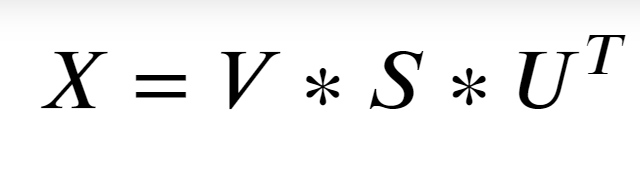

, где S - диагональная матрица сингулярных значений, а V и U - левые и правые сингулярные векторы соответсвенно

### 2. Подготовка данных

Вектора главых компонент должны проходить через центр выборки, поэтому первым шагом метода главных компонент выступает центрирование данных

In [ ]:
def data_centering(df):
    """Центрирование значений матрицы"""
    
    df_shape = df.shape[1]
    for i in range(df_shape):
        df[i] = df[i] - df[i].mean()

In [ ]:
data_centering(df=df)

### 3. Нахождение ковариационной матрицы

Для дальнейшего нахождения собственных значений и собственных векторов матрицы, необходимо найти ковариацинную матрицу, которая вычисляется по формуле:  

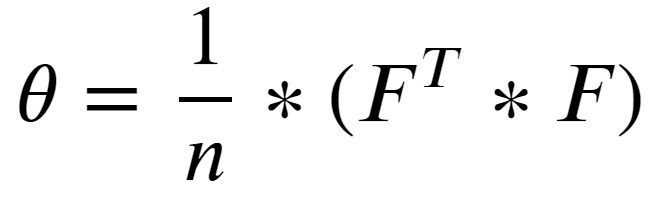

, где F - центрированная матрица, содержащая информацию об n объектов, обладающих p признаками

In [ ]:
def cov_matrix(df):
    """Вычисление ковариционной матрицы"""
    
    df_len = df.shape[0]
    df_matrix = np.array(df)
    cov_matrix = df_matrix.T.dot(df_matrix)
    
    return cov_matrix

In [ ]:
cov = cov_matrix(df=df)

In [ ]:
# Ковариационная матрица
pd.DataFrame(cov)

,0,1,2,3,4
0,1726.876898,-376.871187,3601.287763,-867.879972,-1282.894558
1,-376.871187,3599.524547,4922.905813,1380.684961,-154.375589
2,3601.287763,4922.905813,18388.984710,-435.503462,-3764.179372
3,-867.879972,1380.684961,-435.503462,4700.371989,656.912167
4,-1282.894558,-154.375589,-3764.179372,656.912167,1248.048325


### 4. Нахождение собственных чисел и векторов 

Далее необходимо найти собственные числа и собственные векторы матрицы ковариаций, которые эквивалентны собственным числам и векторам исходной матрицы F. Для этого используем формулу определителя матрицы:

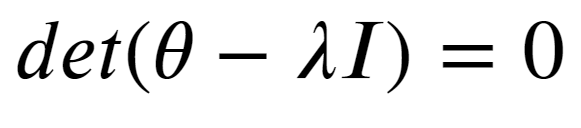

, где тетта - ковариационная матрица, I - единичная диагональная матрица, а лямда - собственные числа. После раскрытия определителя у нас появится полиномальное уравнение, для нахождения его коэффициентов применим **метод Леверрье**, который основан на формулах Ньютона для сумм степеней корней алгебраического уравнения. Коэффициенты вычисляются по следующей формуле, где S - сумма  элементов главной диагонали матрицы

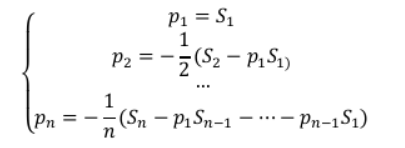

In [ ]:
def sum_main_diag(df):
    """Сумма элементов главной диагонали матрицы"""
    
    p = 0
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if row == col:
                p += df[row][col]
    return p


def find_char_coef(cov):
    """Нахождение коэффициентов характеристического уравнения"""
    
    a1 = cov
    e = np.eye(len(cov))
    p1 = sum_main_diag(a1)
    b1 = a1 - p1*e
    b = b1
    
    list_p = [1,-p1]
    for num in range(2, a1.shape[0]+1):
        a = a1.dot(b)
        p = 1/num * sum_main_diag(a)
        list_p.append(-p)
        b = a - p*e
        
    return list_p

In [ ]:
# Коэффициенты характеристического уравнения
find_char_coef(cov)

[1,
 -29663.806469132513,
 194632719.49444473,
 -331471657504.2726,
 81403248093782.16,
 -5381907945836629.0]

Далее решаем полином, с уже найденными коэффициентами и находим собственные числа матрицы F

In [ ]:
def solve_poly(coeff):
    """Решение полинома с найденными коеффициентами"""
    
    res = np.roots(coeff)
    return res

In [ ]:
own_numbers = solve_poly(find_char_coef(cov))

In [ ]:
# Собственные числа матрицы F
own_numbers

array([21218.91478748,  5960.89614931,  2205.02025068,   152.13039356,
         126.8448881 ])

   Следующим этапом идет нахождение ортононормированных собственных векторов матрицы F, которые в том числе соответствуют собственным векторам ковариационной матрицы. Они вычисляются, с помощью линейных уравнений, исходя из формулы определителя матрицы. 

При таком решении, может получится тривиальный результат, где значения векторов примут нули. Нас такой случай не устраивает, поэтому зададим изначальное значение одной из неизвестных. Для того, чтобы в последующем сравнить результаты с работой библитеки numpy, возьмем начальное значение собственных векторов, полученных при помощи np.linalg.eig. Мы бы могли взять любое значение, например 0 и 1, но для проверки эксперимента, возьмем эти значения 

In [ ]:
def gener_value_dict():
    np_own_vectors= np.linalg.eig(cov)[1][4]
    keys = range(np_own_vectors.shape[0])
    values = np_own_vectors
    value_dict = dict(zip(keys, values))
    
    return value_dict

In [ ]:
# Начальные значения одной из неизвестных СЛАУ
gener_value_dict()

{0: -0.18957776981862784,
 1: 0.18966797279633762,
 2: 0.2697062222108464,
 3: -0.28933924089955443,
 4: 0.8784234096734579}

In [ ]:
def find_own_vectors(cov, own_numbers):
    """Нахождение собственных векторов"""
    
    own_vectors_df = pd.DataFrame(columns=[1,2,3,4,5])
    for number in range(len(own_numbers)):
        matrix = cov.copy()
        for row in range(matrix.shape[0]):
            for col in range(matrix.shape[1]):
                if row == col:
                    matrix[row][col] = matrix[row][col] - own_numbers[number]
                    
        M1 = matrix[:-1,:-1]
        v1 = -gener_value_dict()[number] * matrix[:-1,-1]
        own_vector = np.linalg.solve(M1, v1)
        own_vector = np.append(own_vector, gener_value_dict()[number])
        
        own_vectors_df.loc[number,:] = own_vector
        
    return own_vectors_df

In [ ]:
own_vector = np.array(find_own_vectors(cov, own_numbers))

In [ ]:
# Собственные вектора матрицы F
own_vector

array([[0.18030654892972084, 0.2561652634550697, 0.9303354234904235,
        -0.020128964242736726, -0.18957776981862784],
       [-0.28199341362589375, 0.4701237426730512, -0.018526117421213587,
        0.8143379054885139, 0.18966797279633762],
       [-0.4565851490744485, 0.6182857728911184, -0.03931659500493311,
        -0.5787620095882624, 0.2697062222108464],
       [-0.823721729633318, -0.43317592985615, 0.22076389860242568,
        0.03724556101079607, -0.28933924089955443],
       [-0.03133333120418822, -0.3787404671972964, 0.28956914422415037,
        0.009793106102544715, 0.8784234096734579]], dtype=object)

### 5. Сингулярное разложение

Мы нашли собственные вектора и собственные значения матрицы F, далее приступим к сингулярному разложению. Сначала найдем s - диагональную матрицу сингулярных значений и v - матрицу левых сингулярных векторов

In [ ]:
def create_own_numbers_diag_matr(own_numbers):
    """Создание диагональной матрицы сингулярных значений"""
    
    own_numbers_sqrt = own_numbers**(0.5)
    own_numbers_diag = np.diag(own_numbers_sqrt)
    return own_numbers_diag

In [ ]:
s = create_own_numbers_diag_matr(own_numbers)

In [ ]:
def calc_V(F, s, u):
    """Вычисление матрицы правых сингулярных векторов"""
    
    v = F.dot(u.T).dot(np.linalg.inv(s))
    return v

In [ ]:
v = calc_V(np.array(df), s, own_vector)

Теперь проверим, правильно ли мы разложили матрицу F, с помощью спектрального разложения

In [ ]:
def calc_F(v, s, u):
    """Проверка правильного сингулярного разложения матрицы"""
    
    F = v.dot(s).dot(u)
    if_coincide = np.allclose(np.array(df), np.array(F, float))
    if if_coincide == True:
        print('Сингулярное разложение матрицы реализовано верно')
    else:
        print('Сингулярное разложение матрицы реализовано не верно')

In [ ]:
calc_F(v, s, own_vector)

Сингулярное разложение матрицы реализовано верно


### 6. Опрделение достаточного количества компонент

Далее построим график зависимости доли объясненной дисперсии от количества главных компонент, для того, чтобы проанализировать оптимальное количество главных компонент для данной задачи

In [ ]:
def explained_variance_plot(own_numbers):
    """Построение графика зависимости доли объясненной дисперсии от количества главных компонент"""
    
    own_numbers_df = pd.DataFrame(own_numbers)
    ratio_func = lambda x: x/own_numbers.sum()
    explained_variance_ratio = own_numbers_df.apply(ratio_func)
    explained_variance_ratio_cumsum = np.cumsum(explained_variance_ratio[0])
    component_range = range(1, len(explained_variance_ratio)+1)
    
    plt.plot(component_range,explained_variance_ratio_cumsum)
    plt.xlabel('Количество главных компонент', fontsize=14)
    plt.ylabel('Доля объясненной дисперсии', fontsize=14)

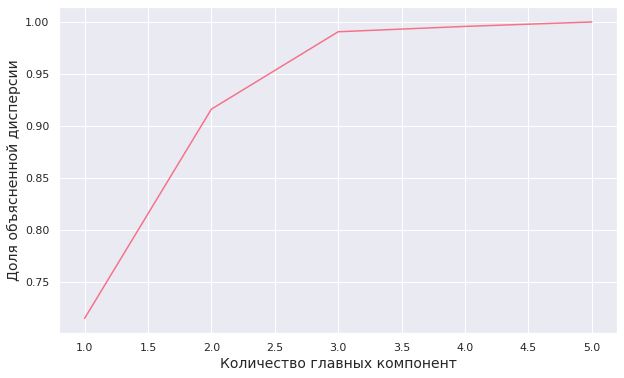

In [ ]:
explained_variance_plot(own_numbers)

In [ ]:
def own_numbers_plot(own_numbers):
    """Построение графика зависимости доли объясненной дисперсии от количества главных компонент"""
    
    component_range = range(1, len(own_numbers)+1)
    plt.plot(component_range,own_numbers)
    plt.xlabel('Количество главных компонент', fontsize=14)
    plt.ylabel('Собственные значения матрицы', fontsize=14)

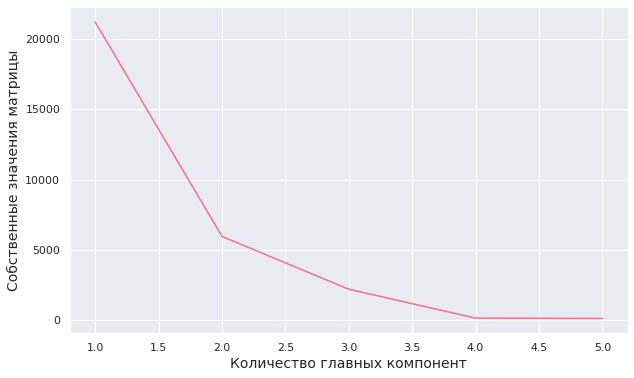

In [ ]:
own_numbers_plot(own_numbers)

In [ ]:
first_three = own_numbers[0:3]
own_numbers_df = pd.DataFrame(first_three)
ratio_func = lambda x: x/first_three.sum()
explained_variance_ratio = own_numbers_df.apply(ratio_func)
explained_variance_ratio_cumsum = np.cumsum(explained_variance_ratio[0])
sum = explained_variance_ratio_cumsum[2]
print(f'Первые 3 главные компоненты описывают {sum} процентов дисперсии данных')

Первые 3 главные компоненты описывают 1.0 процентов дисперсии данных


Из графика видно, что 3 первых главных компоненты описывают практически 100 процентов дисперсии данных. Таким образом, используя метод главных компонент, мы определили, что **достаточное количество компонент для описания процесса - 3**. 